In [1]:
import os
import re
import numpy as np
import pandas as pd

import torch
from sentence_transformers import SentenceTransformer

import umap
import hdbscan

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import matplotlib.pyplot as plt

D:\Conda\envs\nlp-gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\Conda\envs\nlp-gpu\Lib\site-packages\transformers\utils\hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
DATA_PATH = "datasets/parsing.csv"

df = pd.read_csv(DATA_PATH)
df = df.copy()

def pick_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

COL_ID = pick_col(df, ["id", "ID"])
COL_NAME = pick_col(df, ["name", "Название", "title", "Наименование"])
COL_CATEGORY = pick_col(df, ["category", "Категория"])
COL_SUBCATEGORY = pick_col(df, ["subcategory", "Подкатегория"])
COL_BRAND = pick_col(df, ["brand", "Бренд"])
COL_SELLER = pick_col(df, ["seller", "Продавец"])
COL_DESCRIPTION = pick_col(df, ["description", "Описание"])

COL_PRICE = pick_col(df, ["price", "Цена ₽", "Цена", "cost"])
COL_RATING = pick_col(df, ["rating", "Рейтинг", "оценка"])
COL_FEEDBACKS = pick_col(df, ["feedbacks", "Отзывы", "Количество отзывов", "отзывы"])

print("rows:", len(df))
print("text cols:", [c for c in [COL_NAME, COL_BRAND, COL_CATEGORY, COL_SUBCATEGORY, COL_SELLER, COL_DESCRIPTION] if c])
print("num cols:", [c for c in [COL_PRICE, COL_RATING, COL_FEEDBACKS] if c])
df.head(3)

rows: 84
text cols: ['name', 'brand', 'category', 'subcategory', 'seller', 'description']
num cols: ['price', 'rating', 'feedbacks']


,id,name,brand,price,rating,feedbacks,image,description,seller,category,subcategory,sellerrating,sellerfeedback,sellerordes,url
0,2315339908,"Крем от варикоза, для сосудов, отеков и тяжест...",NaN,185,4.7,294,https://ir-5.ozone.ru/s3/multimedia-1-r/795847...,Описание:Вес нетто: 20 гФункция:1. Улучшает ва...,gosneui,gosneui,Аптека > Парафармацевтика > Лечебные средства ...,NaN,65326,NaN,https://www.ozon.ru/product/krem-ot-varikoza-d...
1,2623222451,"Статуэтка йоги Бегемот, настольный декор для д...",NaN,126,3.3,172,https://ir-5.ozone.ru/s3/multimedia-1-0/770024...,Материал: смолаРазмер: как на фотоЦвет: как на...,gosneui,gosneui,Дом и сад > Декор и интерьер > Оформление инте...,NaN,65326,NaN,https://www.ozon.ru/product/statuetka-yogi-beg...
2,2648920196,40 мл крема для ног с мочевиной 60% для очень ...,NaN,176,5.0,9,https://ir-5.ozone.ru/s3/multimedia-1-u/771080...,Описание Срок годности: 3 года Содержимое нетт...,gosneui,gosneui,Красота и здоровье > Уход за телом > Кремы > К...,NaN,65326,NaN,https://www.ozon.ru/product/40-ml-krema-dlya-n...


In [3]:
def safe_str(x) -> str:
    if pd.isna(x):
        return ""
    return str(x).strip()

def build_text(row: pd.Series) -> str:
    parts = []
    if COL_NAME: 
        v = safe_str(row.get(COL_NAME))
        if v: parts.append(v.lower())
    if COL_BRAND:
        v = safe_str(row.get(COL_BRAND))
        if v: parts.append(f"brand: {v}".lower())
    if COL_CATEGORY:
        v = safe_str(row.get(COL_CATEGORY))
        if v: parts.append(f"category: {v}".lower())
    if COL_SUBCATEGORY:
        v = safe_str(row.get(COL_SUBCATEGORY))
        if v: parts.append(f"subcategory: {v}".lower())
    if COL_SELLER:
        v = safe_str(row.get(COL_SELLER))
        if v: parts.append(f"seller: {v}".lower())
    if COL_DESCRIPTION:
        v = safe_str(row.get(COL_DESCRIPTION))
        if v: parts.append(f"desc: {v}".lower())
    txt = " ".join(parts)
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

df["text"] = df.apply(build_text, axis=1)
df["text"].head()

0    крем от варикоза, для сосудов, отеков и тяжест...
1    статуэтка йоги бегемот, настольный декор для д...
2    40 мл крема для ног с мочевиной 60% для очень ...
3    подарочный набор карандашей для студентов 6-в-...
4    подарочный набор карандашей для студентов 6-в-...
Name: text, dtype: object

In [4]:
def to_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

price = to_num(df[COL_PRICE]) if COL_PRICE else pd.Series([np.nan]*len(df))
rating = to_num(df[COL_RATING]) if COL_RATING else pd.Series([np.nan]*len(df))
feedbacks = to_num(df[COL_FEEDBACKS]) if COL_FEEDBACKS else pd.Series([np.nan]*len(df))

price = price.fillna(price.median()) if price.notna().any() else price.fillna(0)
rating = rating.fillna(rating.mean()) if rating.notna().any() else rating.fillna(0)
feedbacks = feedbacks.fillna(feedbacks.median()) if feedbacks.notna().any() else feedbacks.fillna(0)

df["price_log"] = np.log1p(price.clip(lower=0))
df["rating_num"] = rating
df["feedbacks_log"] = np.log1p(feedbacks.clip(lower=0))

numeric = df[["price_log", "rating_num", "feedbacks_log"]].to_numpy(dtype=float)

scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric)

print("numeric_scaled:", numeric_scaled.shape)
df[["price_log", "rating_num", "feedbacks_log"]].head()

numeric_scaled: (84, 3)


,price_log,rating_num,feedbacks_log
0,5.225747,4.7,5.686975
1,4.844187,3.3,5.153292
2,5.176150,5.0,2.302585
3,4.653960,4.6,5.365976
4,4.584967,4.7,1.386294


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

EMBED_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

embed_model = SentenceTransformer(EMBED_MODEL_NAME, device=device)

embeddings = embed_model.encode(
    df["text"].tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print("embeddings:", embeddings.shape)

device: cuda


Batches: 100%|███████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.14it/s]

embeddings: (84, 384)


In [6]:
w_text = 1.0
w_num = 0.25

X_text = embeddings * w_text
X_num = numeric_scaled * w_num

X_full = np.hstack([X_text, X_num])

X_full = normalize(X_full)

print("X_full:", X_full.shape)

X_full: (84, 387)


In [7]:
umap_cluster = umap.UMAP(
    n_neighbors=7,
    n_components=15,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)
Z = umap_cluster.fit_transform(X_full)


clusterer = hdbscan.HDBSCAN(
    min_cluster_size=4,
    min_samples=2,
    metric="euclidean",
    cluster_selection_method="leaf"
)
labels = clusterer.fit_predict(Z)
df["cluster"] = labels
df["cluster_prob"] = clusterer.probabilities_
df["cluster"].value_counts()


print("clusters:", sorted(df["cluster"].unique().tolist()))
print("noise share:", float((df["cluster"] == -1).mean()))
df["cluster"].value_counts()

D:\Conda\envs\nlp-gpu\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


clusters: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
noise share: 0.23809523809523808


cluster
-1    20
 1    11
 4    10
 3     7
 7     7
 8     6
 2     6
 5     5
 0     4
 6     4
 9     4
Name: count, dtype: int64

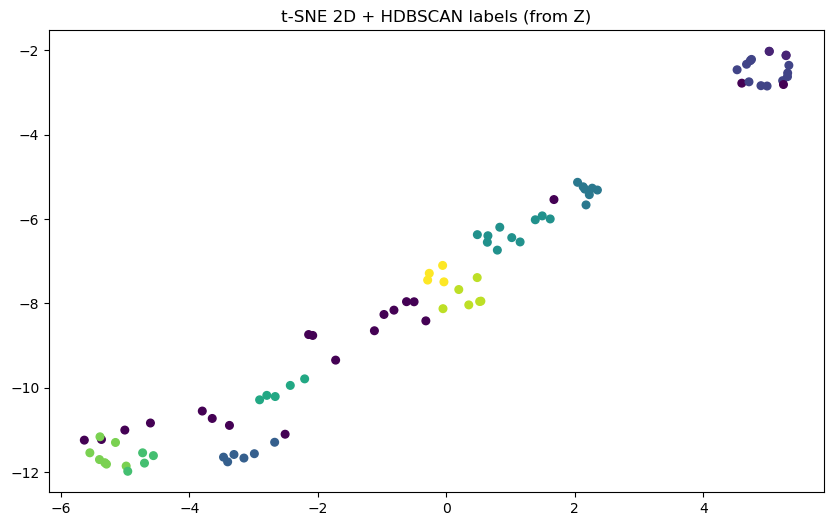

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE


def plot_cluster_map_2d(Z, labels, method="umap", random_state=42):
    if method == "umap":
        reducer = umap.UMAP(
            n_neighbors=10,
            n_components=2,
            min_dist=0.1,
            metric="euclidean",     # для Z (UMAP-выхода) обычно ок
            random_state=random_state,
        )
        Z2 = reducer.fit_transform(Z)
        title = "UMAP 2D + HDBSCAN labels (from Z)"
    elif method == "tsne":
        # TSNE чувствителен, но иногда даёт “острова” нагляднее
        perplexity = max(5, min(30, (len(Z) - 1) // 3))
        reducer = TSNE(
            n_components=2,
            perplexity=perplexity,
            init="pca",
            learning_rate="auto",
            random_state=random_state,
        )
        Z2 = reducer.fit_transform(Z)
        title = "t-SNE 2D + HDBSCAN labels (from Z)"
    else:
        raise ValueError("method must be 'umap' or 'tsne'")

    plt.figure(figsize=(10, 6))
    plt.scatter(Z2[:, 0], Z2[:, 1], c=labels, s=30)
    plt.title(title)
    plt.show()
    return Z2

#Z2_umap = plot_cluster_map_2d(Z, labels, method="umap")

Z2_tsne = plot_cluster_map_2d(Z, labels, method="tsne")


In [8]:
def top_counts(s: pd.Series, k=3) -> str:
    s = s.dropna().astype(str)
    if len(s) == 0:
        return ""
    vc = s.value_counts().head(k)
    return ", ".join([f"{idx}({cnt})" for idx, cnt in vc.items()])

def representatives_idx(indices: np.ndarray, X: np.ndarray, k=3) -> list[int]:
    if len(indices) == 0:
        return []
    C = X[indices]
    centroid = C.mean(axis=0, keepdims=True)
    sims = (C @ centroid.T).reshape(-1)  # cosine-похоже, т.к. X_full нормализован
    order = np.argsort(-sims)[:k]
    return indices[order].tolist()

clusters = sorted([c for c in df["cluster"].unique() if c != -1])

rows = []
for c in clusters:
    sub = df[df["cluster"] == c]
    idx = sub.index.to_numpy()
    reps = representatives_idx(idx, X_full, k=3)

    row = {
        "cluster": c,
        "size": len(sub),
        "mean_prob": float(sub["cluster_prob"].mean()) if "cluster_prob" in sub else np.nan,
        "top_brand": top_counts(sub[COL_BRAND], 3) if COL_BRAND else "",
        "top_category": top_counts(sub[COL_CATEGORY], 3) if COL_CATEGORY else "",
        "top_subcategory": top_counts(sub[COL_SUBCATEGORY], 3) if COL_SUBCATEGORY else "",
        "median_price": float(sub["price_log"].median()),
        "median_rating": float(sub["rating_num"].median()),
        "median_feedbacks": float(sub["feedbacks_log"].median()),
        "representatives_idx": reps
    }
    rows.append(row)

summary = pd.DataFrame(rows).sort_values(["size","mean_prob"], ascending=[False, False]).reset_index(drop=True)
summary


,cluster,size,mean_prob,top_brand,top_category,top_subcategory,median_price,median_rating,median_feedbacks,representatives_idx
0,1,11,0.907005,,"gosneui(10), Аксессуары(1)",Аксессуары > Женские аксессуары > Головные убо...,5.030438,4.70,2.995732,"[42, 48, 51]"
1,4,10,0.840908,"Berlingo(3), ТРЕК ПРИНТ(1), Le Goods(1)",Канцелярские товары(10),Подставки и визитницы > Подставки для канцеляр...,5.592641,4.90,8.080915,"[66, 24, 71]"
2,7,7,0.956352,СПРУТ(1),"Одежда(6), Аксессуары(1)","Женская одежда > Толстовки, свитшоты и худи(2)...",6.317165,4.70,7.424762,"[31, 21, 17]"
3,3,7,0.749503,TEZOR(1),"gosneui(6), Канцелярские товары(1)",Канцелярские товары > Письменные принадлежност...,4.653960,4.60,5.365976,"[3, 11, 49]"
4,8,6,0.963007,"Clean cat(1), Стамм(1), Lemon Moon(1)","Дом и сад(4), Канцелярские товары(1), Продукты...",Хозяйственные товары > Инвентарь для уборки > ...,5.356186,4.90,10.087682,"[20, 15, 61]"
5,2,6,0.911760,"Intro(1), Германия ОПТ(1), YYC(1)","Туризм, рыбалка, охота(2), Дом и сад(2), Строи...","Электрика > Розетки, вилки и выключатели > Сет...",6.455561,4.90,10.156595,"[29, 67, 57]"
6,5,5,0.999968,"Attache(1), KEANTI(1)","Аксессуары(2), Строительство и ремонт(2), Хобб...","Женские аксессуары > Перчатки и варежки(1), Ср...",6.030685,4.80,9.484253,"[78, 23, 18]"
7,0,4,1.000000,,gosneui(4),Дом и сад > Декор и интерьер > Оформление инте...,4.844187,3.30,5.153292,"[1, 5, 6]"
8,6,4,1.000000,"Мистраль(1), Колесник(1), Snaiden(1)",Обувь(4),"Мужская обувь > Рабочая обувь > Мистраль(1), Ж...",6.742732,4.85,8.583051,"[72, 36, 13]"
9,9,4,1.000000,"Brauberg(1), deVENTE(1), Alingar(1)","Канцелярские товары(3), Электроника(1)",Офисные принадлежности > Канцелярские мелочи >...,4.740184,4.95,7.250650,"[79, 30, 28]"


In [9]:
OBJ_COL = COL_NAME if COL_NAME else (COL_ID if COL_ID else None)

def show_cluster(c: int, n=20):
    sub = df[df["cluster"] == c].copy()
    sub = sub.sort_values("cluster_prob", ascending=False)
    cols = [x for x in [OBJ_COL, COL_CATEGORY, COL_SUBCATEGORY, COL_BRAND, COL_PRICE, COL_RATING, COL_FEEDBACKS, "cluster_prob"] if x]
    display(sub[cols].head(n))


show_cluster(0, n=15)

,name,category,subcategory,brand,price,rating,feedbacks,cluster_prob
1,"Статуэтка йоги Бегемот, настольный декор для д...",gosneui,Дом и сад > Декор и интерьер > Оформление инте...,NaN,126,3.3,172,1.0
5,"Статуэтка йоги Бегемот, настольный декор для д...",gosneui,Дом и сад > Декор и интерьер > Оформление инте...,NaN,126,3.3,172,1.0
6,"Статуэтка йоги Бегемот, настольный декор для д...",gosneui,Дом и сад > Декор и интерьер > Оформление инте...,NaN,126,3.3,172,1.0
46,"Статуэтка йоги Бегемот, настольный декор для д...",gosneui,Дом и сад > Декор и интерьер > Оформление инте...,NaN,126,3.3,172,1.0


D:\Conda\envs\nlp-gpu\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


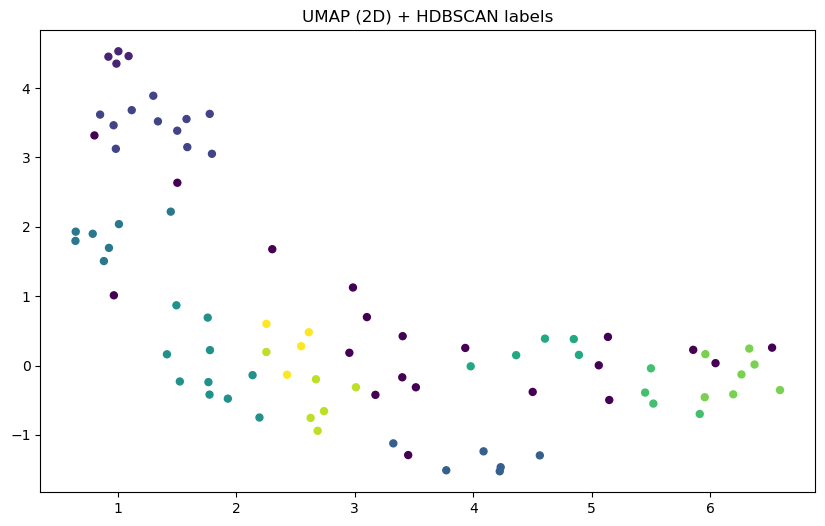

In [10]:
umap_vis = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)
Z2 = umap_vis.fit_transform(X_full)  # <-- тут было у тебя X, вот из-за этого NameError

plt.figure(figsize=(10,6))
plt.scatter(Z2[:,0], Z2[:,1], c=df["cluster"], s=25)
plt.title("UMAP (2D) + HDBSCAN labels")
plt.show()


In [11]:
OUT_CSV = "clusters_result.csv"
OUT_SUMMARY_CSV = "clusters_summary.csv"
OUT_TXT = "clusters_summary_2.txt"

df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
summary.to_csv(OUT_SUMMARY_CSV, index=False, encoding="utf-8-sig")

with open(OUT_TXT, "w", encoding="utf-8") as f:
    f.write("CLUSTERS SUMMARY (HDBSCAN)\n\n")
    f.write(f"rows: {len(df)}\n")
    f.write(f"clusters: {len(clusters)}\n")
    f.write(f"noise share: {(df['cluster']==-1).mean():.3f}\n\n")

    for _, r in summary.iterrows():
        c = int(r["cluster"])
        f.write(f"CLUSTER {c} | size={int(r['size'])} | mean_prob={r['mean_prob']:.3f}\n")
        f.write(f"brands: {r['top_brand']}\n")
        f.write(f"category: {r['top_category']}\n")
        f.write(f"subcategory: {r['top_subcategory']}\n")
        f.write(f"representatives_idx: {r['representatives_idx']}\n")

        sub = df[df["cluster"] == c]
        if OBJ_COL:
            for v in sub[OBJ_COL].astype(str).tolist():
                f.write(f"- {v}\n")
        else:
            for idx in sub.index.tolist():
                f.write(f"- idx={idx}\n")
        f.write("\n")

print("saved:", OUT_CSV, OUT_SUMMARY_CSV, OUT_TXT)

saved: clusters_result.csv clusters_summary.csv clusters_summary_2.txt
